In [1]:
from extract_data import extract_data
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.optimize import linear_sum_assignment
from genSankey import genSankey
import chart_studio.plotly as py
import plotly

import plotly.graph_objs as go

from random import seed
from random import randint

In [2]:
#importing cleaned data
data = extract_data("data","data",1)

In [3]:
data['generalElectionVote'].unique()

['Plaid Cymru', 'Conservative', 'Liberal Democrat', 'Labour', 'Don't know', ..., 'Green Party', 'Scottish National Party (SNP)', 'United Kingdom Independence Party (UKIP)', 'Other', 'An independent candidate']
Length: 12
Categories (12, object): ['Plaid Cymru', 'Conservative', 'Liberal Democrat', 'Labour', ..., 'Scottish National Party (SNP)', 'United Kingdom Independence Party (UKIP)', 'Other', 'An independent candidate']

In [4]:
#removing don't know's and no votes from the labels, label choice is who people voted in the general election
data['generalElectionVote'] = data['generalElectionVote'].fillna("Don't know") 

list_to_remove = []
for i in range(data.shape[0]):
    if data.loc[i,'generalElectionVote'] == "Don't know":
        list_to_remove.append(i)
    elif data.loc[i,'generalElectionVote'] == "No - none":
        list_to_remove.append(i)
    elif data.loc[i,'generalElectionVote'] == "Plaid Cymru":
        list_to_remove.append(i)
    elif data.loc[i,'generalElectionVote'] == "Scottish National Party (SNP)":
        list_to_remove.append(i)
    elif data.loc[i,'generalElectionVote'] ==    'I would/did not vote':
        list_to_remove.append(i)
    elif data.loc[i,'generalElectionVote'] ==  'Other':
        list_to_remove.append(i)
        
        
    
data = data.drop(list_to_remove)
data = data.reset_index(drop=True)



In [5]:
#importing k-modes required packages
from kmodes.kmodes import KModes, labels_cost
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_array
from collections import defaultdict
from kmodes.util.dissim import matching_dissim, ng_dissim
from kmodes.util.__init__ import  pandas_to_numpy, encode_features

In [6]:
#function to find the cost matrix of the cluster assignments
def cost_matrices(X, centroids, dissim, membship=None):
   
    X = check_array(X)
    n_centroids = centroids.shape[0]
    n_points = X.shape[0]
    cost = np.empty(shape=[n_points,n_centroids], dtype=np.uint16)
    labels = np.empty(n_points, dtype=np.uint16)
    for ipoint, curpoint in enumerate(X):
        diss = dissim(centroids, curpoint, X=X, membship=membship)
        cost[ipoint,:]=diss
        clust = np.argmin(diss)
        labels[ipoint] = clust
    

    return cost

In [7]:
from purity_check import purity_check

In [8]:
#converting data to matrices and dropping certain features including the labels
k_modes_data = data.drop(['generalElectionVote','enviroGrowth','immigCultural','immigSelf','immigEcon','EUIntegrationSelf','happyEULeave'],axis=1)
k_modes_data_matrix = k_modes_data.to_numpy()


In [23]:
cluster_numbers =[]
sum_of_squared_distances = []
for i in range(6,20):
    cluster_numbers.append(i)
    kmodes = KModes(n_jobs = -1, n_clusters = i, init = 'Huang', random_state = 0)
    kmodes.fit_predict(k_modes_data_matrix)
    sum_of_squared_distances.append(kmodes.cost_)
    
    

In [25]:
import matplotlib.pyplot as plt

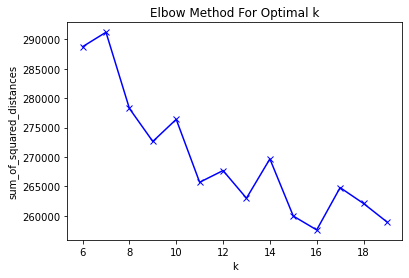

In [26]:
plt.plot(cluster_numbers, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [27]:
n_clusters = 8
kmodes = KModes(n_jobs = -1, n_clusters = n_clusters, init = 'Huang', random_state = 0)
kmodes.fit_predict(k_modes_data_matrix)

array([4, 5, 4, ..., 5, 0, 3], dtype=uint16)

In [28]:
def f1_cluster_assignments_lists(optimal_cluster_assignments,stage=None):
    optimal_cluster_assignments_names = []
    optimal_cluster_assignments_number = []
    for i in range(optimal_cluster_assignments[0].shape[0]):
        name = data.loc[optimal_cluster_assignments[0][i],'generalElectionVote']
        cluster_number = optimal_cluster_assignments[1][i]
        
        if stage != None:
            print(name)
            name = name + "_stage_" + str(stage)
        optimal_cluster_assignments_names.append(name)
        optimal_cluster_assignments_number.append(cluster_number)
    return optimal_cluster_assignments_names, optimal_cluster_assignments_number

In [30]:
labels = pd.DataFrame({'generalElectionVote':data['generalElectionVote']})
labels['Vote'] = labels['generalElectionVote'].cat.remove_unused_categories()
mapping = {item:i for i, item in enumerate(labels["Vote"].unique())}
labels["EnumLabl"] = labels["Vote"].apply(lambda x: mapping[x])

In [33]:
import sklearn.metrics

In [34]:
X = pandas_to_numpy(k_modes_data_matrix)
X = check_array(X, dtype=None)
X, _ = encode_features(X, enc_map=kmodes._enc_map)
costs = cost_matrices(X,kmodes._enc_cluster_centroids,matching_dissim)
optimal_assignments = linear_sum_assignment(costs)
cluster_assignments_names, cluster_assignments_number = f1_cluster_assignments_lists(optimal_assignments)
cluster_assignments = pd.DataFrame({'Party Vote':data['generalElectionVote']})
cluster_assignments['FirstAssignment'] = kmodes.labels_
for x in range(len(cluster_assignments_number)):
    cluster_assignments['FirstAssignment'] = cluster_assignments['FirstAssignment'].replace(int(cluster_assignments_number[x]),cluster_assignments_names[x])
cluster_assignments['FirstAssignment'] = cluster_assignments['FirstAssignment'].astype('category')
cluster_assignments['FirstAssignment'] = cluster_assignments['FirstAssignment'].cat.remove_unused_categories()
cluster_assignments['Party Vote'] = cluster_assignments['Party Vote'].cat.remove_unused_categories()
y_true = np.transpose(np.array(cluster_assignments['Party Vote']))
y_pred = np.transpose(np.array(cluster_assignments['FirstAssignment']))
f1 = sklearn.metrics.f1_score(y_pred,y_true,average='micro')
mean_purity = purity_check(kmodes.labels_,data,n_clusters)

print('F1 score is:',f1)
print('purity is:', mean_purity)

F1 score is: 0.468073676132003
purity is: 0.5885210426813602


In [11]:
#calculating the cost matrix
X = pandas_to_numpy(k_modes_data_matrix)
X = check_array(X, dtype=None)
X, _ = encode_features(X, enc_map=kmodes._enc_map)
costs = cost_matrices(X,kmodes._enc_cluster_centroids,matching_dissim)

In [12]:
#computing the linear sum assignments
def optimal_cluster_assignments_lists(optimal_cluster_assignments,stage=None):
    optimal_cluster_assignments_names = []
    optimal_cluster_assignments_number = []
    for i in range(optimal_cluster_assignments[0].shape[0]):
        name = data.loc[optimal_cluster_assignments[0][i],'generalElectionVote']
        cluster_number = optimal_cluster_assignments[1][i]
        name_count = 0 
        for x in range(len(optimal_cluster_assignments_names)):
                if name in optimal_cluster_assignments_names[x]:
                    name_count += 1
        if name_count != 0:
            name = name + str(name_count+1)
        if stage != None:
            print(name)
            name = name + "_stage_" + str(stage)
        optimal_cluster_assignments_names.append(name)
        optimal_cluster_assignments_number.append(cluster_number)
    return optimal_cluster_assignments_names, optimal_cluster_assignments_number


first_optimal_assignments = linear_sum_assignment(costs)
first_cluster_assignments_names, first_cluster_assignments_number = optimal_cluster_assignments_lists(first_optimal_assignments)
    
    

In [13]:
print(first_cluster_assignments_number)
print(first_cluster_assignments_names)

[1, 2, 5, 0, 4, 3]
['Conservative', 'Labour', 'Labour2', 'Labour3', 'Conservative2', 'Labour4']


In [14]:
#creating a data frame of cluster assignments and theyre original parties
cluster_assignments = pd.DataFrame({"Party Vote" : data.loc[:,'generalElectionVote'] })
cluster_assignments['First Assignment'] = kmodes.labels_



In [15]:
#replacing the numeric cluster assignment with the optimal name
for i in range(len(first_cluster_assignments_number)):
    cluster_assignments['First Assignment'] = cluster_assignments['First Assignment'].replace(int(first_cluster_assignments_number[i]),first_cluster_assignments_names[i])



In [18]:
#performing reassignments - removing a cluster, at the moment this is done manually
kmodes._enc_cluster_centroids = np.delete(kmodes._enc_cluster_centroids,[0,2,5,3],0) # deleting the second cluster

second_assignment = kmodes.predict(k_modes_data_matrix)



In [19]:
cluster_assignments['Second Assignment'] = second_assignment

second_costs = cost_matrices(X,kmodes._enc_cluster_centroids,matching_dissim)

second_optimal_assignments = linear_sum_assignment(second_costs)

second_cluster_assignments_names, second_cluster_assignments_number = optimal_cluster_assignments_lists(second_optimal_assignments,2)


for i in range(len(second_cluster_assignments_number)):
    cluster_assignments['Second Assignment'] = cluster_assignments['Second Assignment'].replace(int(second_cluster_assignments_number[i]),second_cluster_assignments_names[i])


Conservative
Conservative2


In [20]:
cluster_assignments['Second Assignment'].unique()

array(['Conservative2_stage_2', 'Conservative_stage_2'], dtype=object)

In [21]:
index_count = []

for i in range(cluster_assignments.shape[0]):
    index_count.append(i)

cluster_assignments['index'] = index_count
    

In [22]:
figure = genSankey(cluster_assignments,cat_cols=['First Assignment','Second Assignment'],value_cols='index',title='Movement of voters after drop out')

plotly.offline.plot(figure, validate=False)

'temp-plot.html'

In [ ]:
sum(cluster_assignments['First Assignment']=='Conservative')

7327

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 6

kmeans = KMeans(n_clusters, random_state=0).fit(X)

predictions = kmeans.predict(X)

labels = data['generalElectionVote']

kmodes._enc_map





[{'Brexit Party': 0,
  'Conservative': 1,
  "Don't know": 2,
  'Green Party': 3,
  'Labour': 4,
  'Liberal Democrat': 5,
  'No - none': 6,
  'Other': 7,
  'Plaid Cymru': 8,
  'Scottish National Party (SNP)': 9,
  'United Kingdom Independence Party (UKIP)': 10},
 {"Don't know": 0,
  'It is completely necessary': 1,
  'It is completely unnecessary': 2,
  'It is important but not absolutely  necessary': 3,
  'It is not necessary but it would be desirable': 4},
 {'Agree': 0,
  'Disagree': 1,
  "Don't know": 2,
  'Neither agree nor disagree': 3,
  'Strongly agree': 4,
  'Strongly disagree': 5},
 {"Don't know": 0,
  'Getting a little better': 1,
  'Getting a little worse': 2,
  'Getting a lot better': 3,
  'Getting a lot worse': 4,
  'Staying about the same': 5},
 {"Don't know": 0,
  'Got a little better': 1,
  'Got a little worse': 2,
  'Got a lot better': 3,
  'Got a lot worse': 4,
  'Stayed the same': 5},
 {"Don't know": 0,
  'Got a little better': 1,
  'Got a little worse': 2,
  'Got a l

In [ ]:
def kmeans_distance(cluster,data_compare,n_clusters):
    cost_matrix = np.zeros([data_compare.shape[0],n_clusters])
    for i in range(data_compare.shape[0]):
        point_costs = []
        for c in range(n_clusters):
            diss = np.linalg.norm(data_compare[i,:]-cluster[c,:])
            cost_matrix[i,c]=diss
    return cost_matrix

            
            
    

In [ ]:
kmeans_cost = kmeans_distance(kmeans.cluster_centers_,X,n_clusters)


In [ ]:
k_means_assignments = linear_sum_assignment(kmeans_cost)
k_means_assignments_names, k_means_assignments_number = optimal_cluster_assignments_lists(k_means_assignments)

In [ ]:
kmeans.cluster_centers_ = np.delete(kmeans.cluster_centers_,0,0)


In [ ]:
kmeans.cluster_centers_.shape



(5, 32)